## making test plots

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as m
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import netCDF4
# import pandas as pd
import dask
# from mpl_toolkits.basemap import Basemap
# from datetime import datetime
# from datetime import timedelta
# from scipy import stats
# import scipy.interpolate as interp
%matplotlib inline

In [2]:
from functions import ccplot

In [3]:
import seaborn as sns
# Use seaborn style defaults and set default figure size
# plt.style.use('seaborn-pastel')
# sns.set_theme(style="ticks")
# plt.style.use(['science', 'notebook'])
plt.style.use('tableau-colorblind10')

In [4]:
# Colormap selection
xr.set_options(cmap_divergent='BrBG', cmap_sequential='YlGnBu')

In [5]:
fsize = 15
tsize = 18

tdir = 'in'

major = 5.0
minor = 3.0

# plt.style.use(style)
plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = fsize
plt.rcParams['legend.fontsize'] = tsize
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = major
plt.rcParams['ytick.minor.size'] = minor
plt.rcParams['axes.linewidth'] = 1.4
plt.rcParams['legend.handlelength'] = 1.0

In [6]:
# making a new colomap -> tmap

n = 35
diff = 0.5
cmap = plt.cm.BrBG
cmap2 = plt.cm.RdBu_r
lower = cmap(np.linspace(0, diff, n))
lower2 = cmap2(np.linspace(0, diff, n))
white = np.ones((2, 4))
white2 = np.ones((2, 4))
upper = cmap(np.linspace(1-diff, 1, n))
upper2 = cmap2(np.linspace(1-diff, 1, n))
colors = np.vstack((lower, white, upper))
colors2 = np.vstack((lower2, white2, upper2))
tmap = m.colors.LinearSegmentedColormap.from_list('map_white', colors)
tmap2 = m.colors.LinearSegmentedColormap.from_list('map_white', colors2)

In [7]:
n = 35
diff = 0.5
cmap = plt.cm.BrBG
cmap2 = plt.cm.RdBu
lower = cmap(np.linspace(0, diff, n))
white = np.ones((2, 4))
upper = cmap2(np.linspace(1-diff, 1, n))
colors = np.vstack((lower, white, white, upper))
BrBU = m.colors.LinearSegmentedColormap.from_list('map_white', colors)

## Import Data

In [8]:
mfdata_DIR = './data/GPM_lowres_data/*.nc'
gpm = xr.open_mfdataset(mfdata_DIR, chunks=dict(time=-1, lat=-1, lon=-1))

In [9]:
precip = gpm.precipCal.resample(time = '24H').sum() / 2

In [10]:
precip = precip.chunk(dict(time = -1, lat = 40, lon=40))
precip = precip.sel(lat = 22, lon = 88)
precip

<xarray.DataArray 'precipCal' (time: 7700)>
dask.array<getitem, shape=(7700,), dtype=float32, chunksize=(7700,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2000-06-01 2000-06-02 ... 2021-06-30
    lon      float64 88.0
    lat      float64 22.0

In [11]:
era_precip = xr.open_mfdataset('./data/era_precip/*.nc', chunks=dict(time=-1, lat=-1, lon=-1))
era_precip = era_precip.rename({'longitude':'lon', 'latitude':'lat'})
era_precip = era_precip.sel(time = slice("2000-06-01 00:00:00","2021-06-30 23:00:00"), lat = 22, lon = 88)
era_precip = (era_precip.tp*1000).resample(time='24H').sum()
era_precip

<xarray.DataArray 'tp' (time: 7700)>
dask.array<stack, shape=(7700,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2000-06-01 2000-06-02 ... 2021-06-30
    lon      float32 88.0
    lat      float32 22.0

In [12]:
mfdata_DIR2 = './data/era_data/*.nc'
era = xr.open_mfdataset(mfdata_DIR2, chunks=dict(time=-1, lat=40, lon=40))

In [13]:
era = era.sel(expver=1, drop=True)
era = era.transpose('time', 'latitude', 'longitude')
# era = era.rename_dims({'longitude':'lon', 'latitude':'lat'})
era = era.rename({'longitude':'lon', 'latitude':'lat'})
era = era.sel(time = slice("2000-06-01 00:00:00","2021-06-30 23:00:00"), lat = 19, lon = 72)
era

<xarray.Dataset>
Dimensions:  (time: 184800)
Coordinates:
    lon      float32 72.0
    lat      float32 19.0
  * time     (time) datetime64[ns] 2000-06-01 ... 2021-06-30T23:00:00
Data variables:
    u10      (time) float32 dask.array<chunksize=(5136,), meta=np.ndarray>
    v10      (time) float32 dask.array<chunksize=(5136,), meta=np.ndarray>
    d2m      (time) float32 dask.array<chunksize=(5136,), meta=np.ndarray>
    t2m      (time) float32 dask.array<chunksize=(5136,), meta=np.ndarray>
    mx2t     (time) float32 dask.array<chunksize=(5136,), meta=np.ndarray>
    mn2t     (time) float32 dask.array<chunksize=(5136,), meta=np.ndarray>
    sst      (time) float32 dask.array<chunksize=(5136,), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2021-10-02 12:58:09 GMT by grib_to_netcdf-2.20.0: /opt/ecmw...

In [13]:
mfdata_DIR3 = './data/era_pres_data/*.nc'
era_pres = xr.open_mfdataset(mfdata_DIR3, chunks=dict(time=-1, lat=-1, lon=-1))
# era = xr.open_mfdataset(mfdata_DIR2, chunks=dict(time=1000, lat=40, lon=40), engine='netcdf4', parallel=True)
# era = xr.open_mfdataset(mfdata_DIR2, engine='netcdf4', combine='nested', concat_dim='time', parallel=True)
# era_pres = xr.open_mfdataset(mfdata_DIR3, chunks=dict(time=1000, lat=40, lon=40))

In [14]:
era_pres = era_pres.transpose('time', 'level', 'latitude', 'longitude')
# era_pres = era_pres.rename_dims({'longitude':'lon', 'latitude':'lat'})
era_pres = era_pres.rename({'longitude':'lon', 'latitude':'lat'})
era_pres = era_pres.sel(time = slice("2000-06-01 00:00:00","2021-06-30 23:00:00"), lat = 22, lon = 88)
era_pres

<xarray.Dataset>
Dimensions:  (level: 29, time: 184800)
Coordinates:
    lon      float32 88.0
    lat      float32 22.0
  * level    (level) int32 50 70 100 125 150 175 ... 875 900 925 950 975 1000
  * time     (time) datetime64[ns] 2000-06-01 ... 2021-06-30T23:00:00
Data variables:
    q        (time, level) float32 dask.array<chunksize=(720, 29), meta=np.ndarray>
    t        (time, level) float32 dask.array<chunksize=(720, 29), meta=np.ndarray>
    w        (time, level) float32 dask.array<chunksize=(720, 29), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2021-11-11 08:18:32 GMT by grib_to_netcdf-2.23.0: /opt/ecmw...

In [16]:
mfdata_DIR4 = './data/era_data2/era_2010.nc'
era2 = xr.open_mfdataset(mfdata_DIR4, chunks=dict(time=-1, lat=40, lon=40))
# era = xr.open_mfdataset(mfdata_DIR2, chunks=dict(time=1000, lat=40, lon=40), engine='netcdf4', parallel=True)
# era2 = xr.open_mfdataset(mfdata_DIR4, engine='netcdf4', combine='nested', concat_dim='time', parallel=True)
# era2 = xr.open_dataset(mfdata_DIR4, chunks=dict(time=-1, lat=-1, lon=-1))

In [15]:
# era2 = era2.sel(expver=1, drop=True)
era2 = era2.transpose('time', 'latitude', 'longitude')
# era2 = era2.rename_dims({'longitude':'lon', 'latitude':'lat'})
era2 = era2.rename({'longitude':'lon', 'latitude':'lat'})
era2 = era2.sel(time = slice("2000-06-01 00:00:00","2021-06-30 23:00:00"))
era2

<xarray.Dataset>
Dimensions:  (lon: 161, lat: 161, time: 8760)
Coordinates:
  * lon      (lon) float32 60.0 60.25 60.5 60.75 61.0 ... 99.25 99.5 99.75 100.0
  * lat      (lat) float32 40.0 39.75 39.5 39.25 39.0 ... 1.0 0.75 0.5 0.25 0.0
  * time     (time) datetime64[ns] 2010-01-01 ... 2010-12-31T23:00:00
Data variables:
    e        (time, lat, lon) float32 dask.array<chunksize=(8760, 161, 161), meta=np.ndarray>
    vimd     (time, lat, lon) float32 dask.array<chunksize=(8760, 161, 161), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2022-02-04 14:09:44 GMT by grib_to_netcdf-2.23.0: /opt/ecmw...

In [15]:
# t2m = era.t2m.sel(lat = 19, lon = 72).resample(time = '24H').mean()
# d2m = era.d2m.sel(lat = 19, lon = 72).resample(time = '24H').mean()
# vimd = (era2.vimd).sel(lat = 19, lon = 72).resample(time = '24H').mean()
# evap = (era2.e).sel(lat = 19, lon = 72).resample(time = '24H').mean()
# # u = (era.u10).resample(time = '24H').mean()
# # v = (era.v10).resample(time = '24H').mean()
pres = era_pres.coords['level'],
temp = era_pres.t.resample(time = '24H').mean()
omega = era_pres.w.resample(time = '24H').mean()
# q = era_pres.q.resample(time = '24H').mean()

In [16]:
# ds_comb = xr.merge([precip.sel(lat=19, lon=72), t2m, d2m, vimd, evap])
# ds_comb2 = xr.merge([temp, q, omega])
ds_comb = xr.merge([precip, era_precip])
ds_comb2 = xr.merge([temp, omega])

In [17]:
ds_comb

<xarray.Dataset>
Dimensions:    (time: 7700)
Coordinates:
  * time       (time) datetime64[ns] 2000-06-01 2000-06-02 ... 2021-06-30
    lon        float64 88.0
    lat        float64 22.0
Data variables:
    precipCal  (time) float32 dask.array<chunksize=(7700,), meta=np.ndarray>
    tp         (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>

In [18]:
mon = [6,7,8,9]
premon = [3,4,5]
postmon = [10,11,12]
wint = [1,2]

In [19]:
ds_comb_mon = xr.concat([list(ds_comb.groupby('time.month'))[i-1][1] for i in mon], dim='time')
ds_comb_mon2 = xr.concat([list(ds_comb2.groupby('time.month'))[i-1][1] for i in mon], dim='time')

In [20]:
ds_comb_mon = ds_comb_mon.chunk(dict(time = -1)).sortby('time.year')
ds_comb_mon2 = ds_comb_mon2.chunk(dict(time = -1)).sortby('time.year')

In [21]:
ds_comb_mon2

<xarray.Dataset>
Dimensions:  (time: 2592, level: 29)
Coordinates:
  * time     (time) datetime64[ns] 2000-06-01 2000-06-02 ... 2021-06-30
    lon      float32 88.0
    lat      float32 22.0
  * level    (level) int32 50 70 100 125 150 175 ... 875 900 925 950 975 1000
Data variables:
    t        (time, level) float32 dask.array<chunksize=(2592, 29), meta=np.ndarray>
    w        (time, level) float32 dask.array<chunksize=(2592, 29), meta=np.ndarray>

In [22]:
ds_comb_mon_loaded = ds_comb_mon.load()
ds_comb_mon2_loaded = ds_comb_mon2.load()

In [23]:
# ds_comb_mon2_loaded = ds_comb_mon2_loaded.reindex(lat=ds_comb_mon2_loaded.lat[::-1])

In [28]:
ds_comb_mon2_loaded

<xarray.Dataset>
Dimensions:  (time: 2592, level: 29)
Coordinates:
  * time     (time) datetime64[ns] 2000-06-01 2000-06-02 ... 2021-06-30
    lon      float32 88.0
    lat      float32 22.0
  * level    (level) int32 50 70 100 125 150 175 ... 875 900 925 950 975 1000
Data variables:
    t        (time, level) float32 207.4 194.5 193.0 199.5 ... 300.2 301.2 302.9
    w        (time, level) float32 0.002858 0.001014 ... -0.05824 -0.01623

In [65]:
# using_ds1 = ds_comb_mon_loaded.sel(time = "2010-08-29")

In [66]:
# using_ds2 = ds_comb_mon2_loaded.sel(time = "2010-08-29")

In [25]:
precip = ds_comb_mon_loaded.precipCal
era_precip =ds_comb_mon_loaded.tp
# t2m = ds_comb_mon_loaded.t2m
# d2m = ds_comb_mon_loaded.d2m
# vimc = -ds_comb_mon_loaded.vimd
# evap = ds_comb_mon_loaded.e

temp = ds_comb_mon2_loaded.t
# q = ds_comb_mon2_loaded.q
omega = ds_comb_mon2_loaded.w

In [26]:
precip

<xarray.DataArray 'precipCal' (time: 2592)>
array([ 0.        ,  0.        ,  0.28173742, ...,  0.22143084,
        2.5564113 , 27.484726  ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2000-06-01 2000-06-02 ... 2021-06-30
    lon      float64 88.0
    lat      float64 22.0

In [27]:
precip_clim = precip.mean(dim='time')
era_precip_clim = era_precip.mean(dim='time')

In [33]:
precip1 = precip.where(precip > 1)
era_precip1 = era_precip.where(era_precip > 1)

In [34]:
p95 = precip1.quantile(0.95, interpolation='higher')
erap95 = era_precip1.quantile(0.95, interpolation='higher')

In [35]:
p95, erap95

(<xarray.DataArray 'precipCal' ()>
 array(56.261936, dtype=float32)
 Coordinates:
     quantile  float64 0.95,
 <xarray.DataArray 'tp' ()>
 array(31.601542, dtype=float32)
 Coordinates:
     quantile  float64 0.95)

In [40]:
precip_events, precip_idxs = get_events_precip(p95, precip1)
era_precip_events, era_precip_idxs = get_events_precip(erap95, era_precip1)

In [41]:
np.median(precip_events), np.median(era_precip_events)

(79.170876, 40.441025)

In [55]:
temp_events = temp[era_precip_events]
omega_events = omega[era_precip_idxs]
temp_events

<xarray.DataArray 't' (time: 113, level: 29)>
array([[205.51239, 192.97585, 190.89961, ..., 297.15027, 298.68442,
        300.26376],
       [208.4602 , 199.57082, 190.30774, ..., 297.23184, 298.54303,
        300.00583],
       [208.45341, 199.81499, 190.58966, ..., 295.90854, 297.0746 ,
        298.771  ],
       ...,
       [208.92253, 196.32147, 196.11113, ..., 297.11777, 298.33536,
        299.8379 ],
       [206.91559, 196.66512, 198.40112, ..., 297.29398, 298.5424 ,
        300.13336],
       [210.82176, 194.9901 , 198.7704 , ..., 297.55035, 298.78522,
        300.14627]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2000-06-05 2000-08-30 ... 2021-06-19
    lon      float32 88.0
    lat      float32 22.0
  * level    (level) int32 50 70 100 125 150 175 ... 875 900 925 950 975 1000

In [56]:
%time pe, dyn, thermo = get_pe1(temp_events, omega_events, pres)

CPU times: user 9.5 s, sys: 0 ns, total: 9.5 s
Wall time: 9.51 s


In [57]:
(pe*24)

array([ 43.52908256,  39.52084461,  77.45743978, 160.72040208,
        34.3568819 ,  36.70911173,  32.96894327,  30.53158488,
       171.3486683 ,  68.28825311,  46.07438347,  17.96501948,
        67.98972307,  43.73636941,   7.34617636,  35.63217197,
        78.21593234,  40.67799006,  41.86560603,  48.97851284,
        24.99230291,  11.60772498, 117.36046325,  98.56076635,
        31.17439299,  41.69047367,  44.70228975,  61.48229967,
        83.25139522,  38.31741158, 186.14712075,  61.65873921,
        39.72764494,  39.66480774,  56.88792044, 127.48526132,
       165.7184891 , 123.60561684,  48.93271522,  83.11481856,
        85.89058149,  72.75834577,  30.04652624, 161.03800683,
        31.612212  ,  46.09861019,  48.01321943,  70.02130239,
        68.24781854,  21.13123409,  57.8941511 ,  14.7103103 ,
       212.52016871, 341.44313196,  36.39934153,  36.43518905,
        46.52160082,  23.71847291,   8.69231974,  57.32805548,
         2.6050944 ,  52.11597803,  24.75055731,  18.50

In [58]:
# using_pe = (pe*24)[precip_events < 300]
using_pe = (pe*24)[(pe*24) < 1000]

In [59]:
# using_precip_events = precip_events[precip_events < 300]
using_precip_events = era_precip_events[(pe*24) < 1000]

In [50]:
from scipy import stats

Text(0.5, 1.0, 'Lat=22, Lon=88')

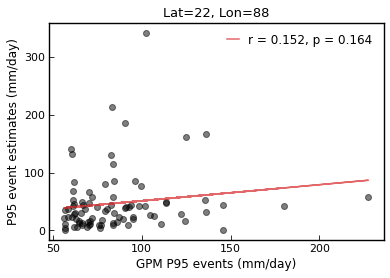

In [51]:
m, b, r, p, _, = stats.linregress(using_precip_events, using_pe)
plt.scatter(using_precip_events, using_pe, color='k', alpha=0.5)
plt.plot(using_precip_events, m*using_precip_events + b, alpha=0.7, color='tab:red', label = f'r = {np.round(r,3)}, p = {np.round(p, 3)}')
# plt.ylim([0, 600])
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.xlabel('GPM P95 events (mm/day)', fontsize=12)
plt.ylabel('P95 event estimates (mm/day)', fontsize=12)
plt.legend(frameon=False, fontsize=12)
plt.title('Lat=22, Lon=88', fontsize=13)
# plt.savefig('./images/pe_era5_corr.pdf', dpi=300)

In [53]:
np.median(using_pe), np.median(using_precip_events) #Mumbai

(34.31544180418154, 79.170876)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f8b28ac25b0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f8b2281ea30>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f8b23e76850>,
 'medians': [<matplotlib.lines.Line2D at 0x7f8b2281e5b0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f8b239417c0>,
 'means': []}

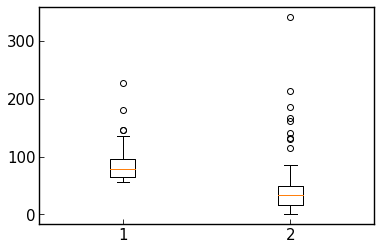

In [54]:
plt.boxplot([using_precip_events, using_pe])

Text(0.5, 1.0, 'Lat=19, Lon=72')

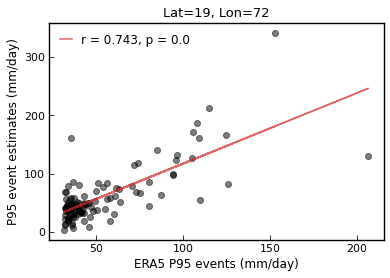

In [60]:
m, b, r, p, _, = stats.linregress(using_precip_events, using_pe)
plt.scatter(using_precip_events, using_pe, color='k', alpha=0.5)
plt.plot(using_precip_events, m*using_precip_events + b, alpha=0.7, color='tab:red', label = f'r = {np.round(r,3)}, p = {np.round(p, 3)}')
# plt.ylim([0, 600])
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.xlabel('ERA5 P95 events (mm/day)', fontsize=12)
plt.ylabel('P95 event estimates (mm/day)', fontsize=12)
plt.legend(frameon=False, fontsize=12)
plt.title('Lat=19, Lon=72', fontsize=13)
# plt.savefig('./images/pe_gpm_corr.pdf', dpi=300)

In [61]:
np.median(using_pe), np.median(using_precip_events) #Mumbai

(46.07438346519828, 40.441025)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f8b24ccd550>,
 'caps': [<matplotlib.lines.Line2D at 0x7f8b24ccdaf0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f8b24ccd280>,
 'medians': [<matplotlib.lines.Line2D at 0x7f8b24cd70d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f8b24cd73a0>,
 'means': []}

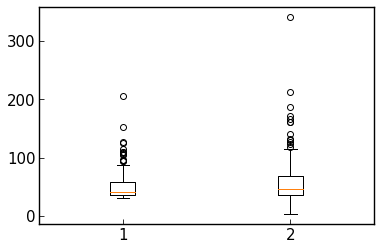

In [62]:
plt.boxplot([using_precip_events, using_pe])

## Spatial

In [30]:
# q.sel(level = 850, time = '2010-06-05 00:00:00').plot.contourf(cmap = 'Greens', levels=9)

In [36]:
from scipy import integrate

In [37]:
from time import sleep

In [65]:
def get_events_precip(p95, preciparr):
    idxs = np.where(preciparr >= p95)
    events = preciparr[idxs]
    return events, idxs

# util function to calculate value of qs
def get_qs(temp, pres):
    a1 = 6.1114
    temp0 = 273.16
    a3w = 17.269
    a4w = 35.86
    a3i = 21.875
    a4i = 7.66

    # calculating saturation vapor pressure using temperature values
    if temp > temp0:
        a3 = a3w
        a4 = a4w
        es = a1 * np.exp(a3 * ((temp - temp0)/(temp - a4)))
    elif temp < temp0 - 23:
        a3 = a3i
        a4 = a4i
        es = a1 * np.exp(a3 * ((temp - temp0)/(temp - a4)))
    else:
        esw = a1 * np.exp(a3w * ((temp - temp0)/(temp - a4w)))
        esi = a1 * np.exp(a3i * ((temp - temp0)/(temp - a4i)))
        es = esi + ((esw - esi)*(((temp - (temp0 - 23))/23)**2))

    # get saturation specific humidity value
    epsilon = 0.622
    qs = (epsilon * es) / (pres - ((1 - epsilon)*es))
    return qs

# vert integral function (Simpson's method)
def vert_integ(x, y):
    int = integrate.simpson(y, x, even='avg')

    return int

# finite differnce methods to find derivative
def centered_diff(arr):
    arr_diff = np.empty(len(arr) - 2)
    for i in range((len(arr) - 2)):
        arr_diff[i] = arr[i+2] - arr[i]
    return arr_diff

def forward_diff(arr):
    arr_diff = np.diff(arr)
    return arr_diff

def backward_diff(arr):
    arr_diff = -(np.diff(arr[::-1])[::-1])
    return arr_diff

def get_pe1(temp, omega, pres):
    pres_range = len(pres)
    time_range = len(temp)
    pe = np.empty(time_range)
    thermo = np.empty(time_range)

    p_cdiff = centered_diff(pres)
    p_fdiff = forward_diff(pres)
    p_bdiff = backward_diff(pres)

    # taking mean omega of all extremes to get the thermodynamic contribution
    qs = np.empty(pres_range)
    omega_mean = omega.mean(dim='time')

    for i in range(time_range):
        for j in range(pres_range):
            qs[j] = get_qs(temp[i, j], pres[j])
        qs_cdiff = centered_diff(qs)/(p_cdiff)
        qs_fdiff = forward_diff(qs)/(p_fdiff)
        qs_bdiff = backward_diff(qs)/(p_bdiff)

        qs_diff = np.insert(qs_cdiff, 0, qs_fdiff[0])
        qs_diff = np.append(qs_diff, qs_bdiff[-1])

        # TODO VARY: the value of 3600 will change for different time calculations
        # 1 hour -> 3600s
        # 3 hour -> 3600*3 and so on
        # '+' sign as pressure is from surface-to-top and not top-to-surface
        pe[i] = np.abs((-1/(9.806)) * vert_integ(pres, omega[i]*qs_diff)) * 3600
        thermo[i] = np.abs((-1/(9.806)) * vert_integ(pres, omega_mean*qs_diff)) * 3600

    dyn = pe - thermo
    return pe, dyn, thermo

In [34]:
from tqdm.notebook import tqdm

In [173]:
def get_mean_freq(precip, pres, temp_levels, q, omega):
    print("Starting the scaling process ...")

    print("Initializing zero arrays ...")

    xrange = len(precip[0])
    yrange = len(precip[0][0])

    # initialising the for loop by making zeros array for t2m and d2m to mutate
    precip95 = np.empty((xrange, yrange))
    precip_mean = np.empty((xrange, yrange))
    # t2m_mean = np.empty((xrange, yrange))
    # d2m_mean = np.empty((xrange, yrange))
    # vimd_mean = np.empty((xrange, yrange))
    pe_mean = np.empty((xrange, yrange))
    dyn_mean = np.empty((xrange, yrange))
    thermo_mean = np.empty((xrange,yrange))
    frequency = np.empty((xrange, yrange))

    print("Starting the loop ...")

    # starting loop
    for lat in tqdm(range(xrange)):
        for lon in tqdm(range(yrange), leave=False):

            # redefine for convenience
            preciparr = precip.isel(lat = lat, lon = lon)
            # t2marr = t2m.isel(lat = lat, lon = lon)
            # d2marr = d2m.isel(lat = lat, lon = lon)
            temparr = temp_levels.isel(lat = lat, lon = lon)
            qarr = q.isel(lat = lat, lon = lon)
            # vimdarr = vimd.isel(lat = lat, lon = lon)
            omegaarr = omega.isel(lat = lat, lon = lon)

            # start
            p95 = preciparr.quantile(0.95, interpolation='higher')
            precip_events, _ = get_events_precip(p95, preciparr[~np.isnan(preciparr)])
            no_of_events = len(precip_events)
            precip_events_mean = np.mean(precip_events)
            # t2m_events = t2marr[precip_idxs]
            # t2m_events_mean = np.mean(t2m_events)
            # d2m_events = d2marr[precip_idxs]
            # d2m_events_mean = np.mean(d2m_events)
            temp_events = temparr[precip_idxs]
            # q_events = qarr[precip_idxs]
            # vimd_events = vimdarr[precip_idxs]
            # vimd_events_mean = np.mean(vimd_mean)
            omega_events = omegaarr[precip_idxs]

            # get the values of qs
            # qs_events  = calc_qs(temp_events, pres)

            # get the value of precipitation estimate
            pe_events, dyn_events, thermo_events = get_pe1(temp_events, omega_events, pres)
            pe_events_mean = np.mean(pe_events)
            dyn_events_mean = np.mean(dyn_events)
            thermo_events_mean = np.mean(thermo_events)

            #### OUTPUT results

            # make 2-D arrays
            precip95[lat, lon] = p95
            precip_mean[lat, lon] = precip_events_mean
            frequency[lat, lon] = no_of_events
            # t2m_mean[lat, lon] = t2m_events_mean
            # d2m_mean[lat, lon] = d2m_events_mean
            # vimd_mean[lat, lon] = vimd_events_mean
            pe_mean[lat, lon] = pe_events_mean
            dyn_mean[lat, lon] = dyn_events_mean
            thermo_mean[lat, lon] = thermo_events_mean

            # print(f"Completed {lat+1}/{xrange} lat and {lon+1}/{yrange} lon", end='\r')
            sleep(0.01)

    # return all the values as  dictionary
    res = {
            # general values and scaling
            "precip_95" : precip95, # 95th percentile precipitation obtaied from new scaling method
            "precip_mean" : precip_mean, # mean of all extreme events at all grid points
            "frequency" : frequency, # no.of events
            # "t2m_mean" : t2m_mean, # mean of all vimd associated with extremes at all grid points
            # "d2m_mean" : d2m_mean, # mean of all vimd associated with extremes at all grid points
            # "vimd_mean" : vimd_mean, # mean of all vimd associated with extremes at all grid points
            "pe_mean" : pe_mean, # mean of all precipitation estimates obtained using METHOD-1
            "dyn_mean" : dyn_mean, # mean of all dyn estimates obtained using METHOD-1
            "thermo_mean" : thermo_mean, # mean of all thermo estimates obtained using METHOD-1
            }

    return res

In [168]:
precip1 = precip.where(precip > 0.1)

In [39]:
pres = ds_comb_mon2_loaded.coords['level'].to_numpy()
pres

array([  50,   70,  100,  125,  150,  175,  200,  225,  250,  300,  350,
        400,  450,  500,  550,  600,  650,  700,  750,  775,  800,  825,
        850,  875,  900,  925,  950,  975, 1000], dtype=int32)

In [119]:
import warnings

In [151]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    res = get_mean_freq(era_precip_loaded, pres, temp, q, omega)

Starting the scaling process ...
Initializing zero arrays ...
Starting the loop ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

In [119]:
from matplotlib.colors import BoundaryNorm as BM

In [152]:
precip95 = res['precip_95']
precip_true = res['precip_mean']
freq = res['frequency']
precip_estimate = res['pe_mean'] * 24
dyn_comp = res['dyn_mean'] * 24
thermo_comp = res['thermo_mean'] * 24

In [153]:
x, y = np.meshgrid(precip1.coords['lon'], precip1.coords['lat'])

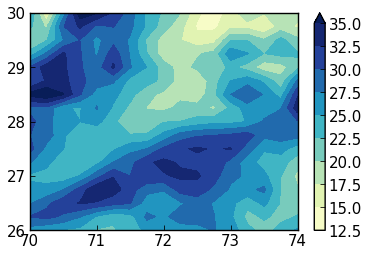

In [162]:
cf = plt.contourf(x, y, np.abs(precip_true), cmap = 'YlGnBu', levels=9, extend = 'max')
plt.colorbar(cf)

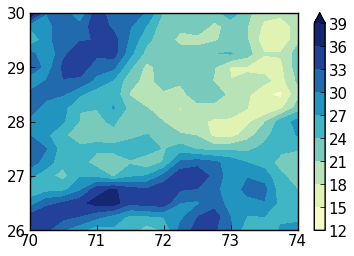

In [163]:
fig, ax = plt.subplots()
cf = ax.contourf(x, y, precip_estimate, cmap = 'YlGnBu', levels=9, extend='max')
plt.colorbar(cf)
# norm = BM(np.arange(0, 210,30), 256, extend='neither')
# fig.colorbar(m.cm.ScalarMappable(norm = norm, cmap='GnBu'), ax = ax, \
#             orientation = 'vertical')

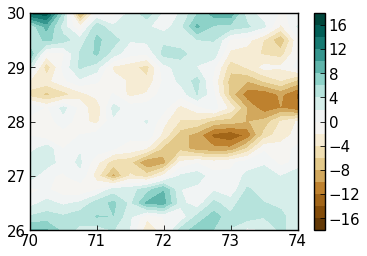

In [171]:
fig, ax = plt.subplots()
cf = plt.contourf(x, y, precip_estimate - precip_true, cmap = tmap, levels=np.arange(-18, 20, 2), extend='neither')
plt.colorbar(cf)

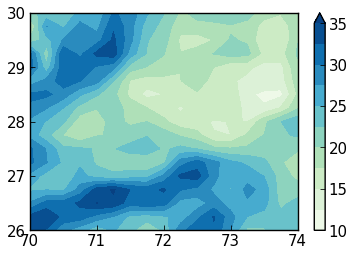

In [160]:
fig, ax = plt.subplots()
cf = ax.contourf(x, y, dyn_comp, cmap = 'GnBu', levels=9, extend='max')
plt.colorbar(cf)

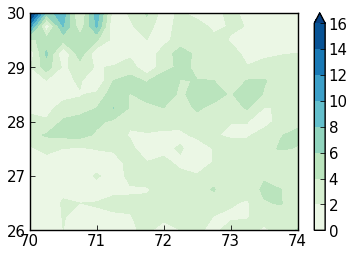

In [161]:
fig, ax = plt.subplots()
cf = ax.contourf(x, y, thermo_comp, cmap = 'GnBu', levels=9, extend='max')
plt.colorbar(cf)

## Single lat,lon

In [99]:
%time pe, dyn, thermo = get_pe1(temp, omega, pres, q)

CPU times: user 3.48 s, sys: 14.9 ms, total: 3.49 s
Wall time: 3.55 s


In [104]:
era_climate = (era_precip.tp*1000).mean()
era_climate_alt = (era_precip.mtpr*3600).mean()
gpm_climate = precip.mean()

In [105]:
era_climate, era_climate_alt, gpm_climate

(<xarray.DataArray 'tp' ()>
 array(7.420363, dtype=float32)
 Coordinates:
     longitude  float32 88.0
     latitude   float32 22.0,
 <xarray.DataArray 'mtpr' ()>
 array(7.419908, dtype=float32)
 Coordinates:
     longitude  float32 88.0
     latitude   float32 22.0,
 <xarray.DataArray 'precipCal' ()>
 array(8.423718, dtype=float32)
 Coordinates:
     lon      float64 88.0
     lat      float64 22.0)

In [43]:
import pandas as pd

In [44]:
# vimc.plot()

In [45]:
time = pd.date_range("2010-06-01", "2010-09-30", freq='1D')
time

DatetimeIndex(['2010-06-01', '2010-06-02', '2010-06-03', '2010-06-04',
               '2010-06-05', '2010-06-06', '2010-06-07', '2010-06-08',
               '2010-06-09', '2010-06-10',
               ...
               '2010-09-21', '2010-09-22', '2010-09-23', '2010-09-24',
               '2010-09-25', '2010-09-26', '2010-09-27', '2010-09-28',
               '2010-09-29', '2010-09-30'],
              dtype='datetime64[ns]', length=122, freq='D')

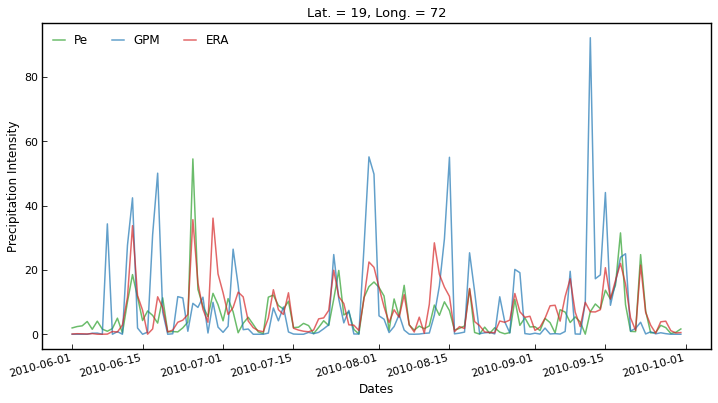

In [106]:
fig = plt.figure(figsize=(12,6))
plt.plot(time, pe*24, color='tab:green', alpha = 0.7, label = 'Pe')
plt.plot(time, (precip).to_numpy(), color='tab:blue', alpha=0.7, label = 'GPM')
plt.plot(time, (era_precip.tp*1000).to_numpy(), color='tab:red', alpha=0.7, label='ERA')
plt.xticks(rotation=15, ha='right')
plt.legend(frameon = False, ncol=3, fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.title('Lat. = 19, Long. = 72', fontsize=13)
plt.ylabel('Precipitation Intensity', fontsize=12)
plt.xlabel('Dates', fontsize=12)
# plt.grid(alpha=0.1)
plt.savefig('./images/Pe_performance2010_mon_kolkata.pdf', dpi=300)

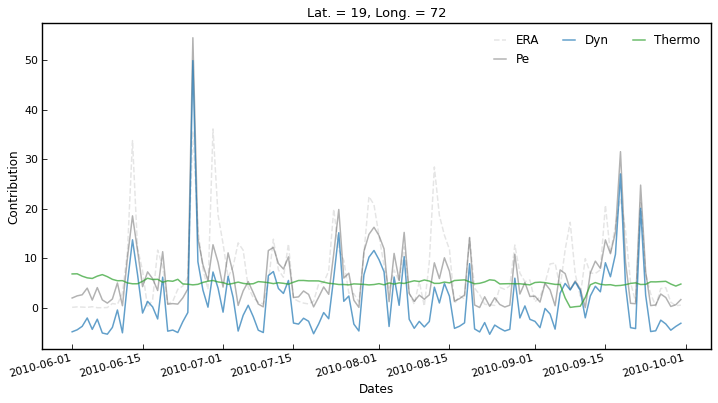

In [107]:
fig = plt.figure(figsize=(12,6))
plt.plot(time, (era_precip.tp*1000), color='k', alpha = 0.1, ls='--', label = 'ERA')
plt.plot(time, pe*24, color='k', alpha = 0.3, label = 'Pe')
plt.plot(time, dyn*24, color='tab:blue', alpha=0.7, label='Dyn')
plt.plot(time, thermo*24, color='tab:green', alpha=0.7, label='Thermo')
plt.xticks(rotation=15, ha='right')
plt.legend(frameon = False, ncol=3, fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.title('Lat. = 19, Long. = 72', fontsize=13)
plt.ylabel('Contribution', fontsize=12)
plt.xlabel('Dates', fontsize=12)
# plt.grid(alpha=0.1)
plt.savefig('./images/Dyn_Thermo2010_mon_kolkata.pdf', dpi=300)

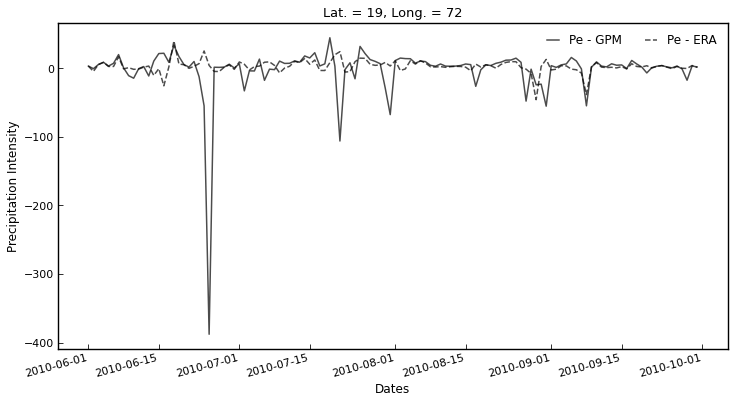

In [91]:
fig = plt.figure(figsize=(12,6))
plt.plot(time, (pe*24 - precip.to_numpy()), color='k', alpha = 0.7, ls='-', label = 'Pe - GPM')
plt.plot(time, (pe*24 - (era_precip.tp*1000).to_numpy()), color='k', alpha=0.7, ls = '--', label='Pe - ERA')
plt.xticks(rotation=15, ha='right')
plt.legend(frameon = False, ncol=3, fontsize=12, loc = 'upper right')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.title('Lat. = 19, Long. = 72', fontsize=13)
plt.ylabel('Precipitation Intensity', fontsize=12)
plt.xlabel('Dates', fontsize=12)
plt.savefig('./images/Pe_error2010_mon_kolkata.pdf', dpi=300)

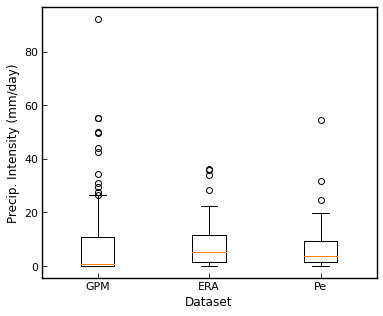

In [109]:
fig = plt.figure(figsize=(6,5))
boxdata = [precip.to_numpy(), (era_precip.tp*1000).to_numpy(), pe*24]
plt.boxplot(boxdata)
plt.gca().set_xticklabels(['GPM', 'ERA', 'Pe'], fontsize=11)
plt.yticks(fontsize=11)
plt.ylabel('Precip. Intensity (mm/day)', fontsize=12)
plt.xlabel('Dataset', fontsize=12)
plt.savefig('./images/dyn_thermo/box_2010_kolkata.pdf', dpi = 300)

In [110]:
precip.quantile(0.95), (era_precip.tp*1000).quantile(0.95), np.quantile(pe*24, 0.95)

(<xarray.DataArray 'precipCal' ()>
 array(42.01027317)
 Coordinates:
     quantile  float64 0.95,
 <xarray.DataArray 'tp' ()>
 array(21.46022596)
 Coordinates:
     quantile  float64 0.95,
 15.24991875709382)

In [111]:
np.median(precip.to_numpy()), np.median((era_precip.tp*1000).to_numpy()), np.median(pe*24)

(0.8986002, 5.0832863, 3.721380016634303)

In [144]:
era_precip = xr.open_dataset('/home/nkv/Downloads/era_precip.nc')
era_precip

<xarray.Dataset>
Dimensions:    (longitude: 161, latitude: 161, time: 2928)
Coordinates:
  * longitude  (longitude) float32 60.0 60.25 60.5 60.75 ... 99.5 99.75 100.0
  * latitude   (latitude) float32 40.0 39.75 39.5 39.25 ... 0.75 0.5 0.25 0.0
  * time       (time) datetime64[ns] 2010-06-01 ... 2010-09-30T23:00:00
Data variables:
    mcpr       (time, latitude, longitude) float32 ...
    mlspr      (time, latitude, longitude) float32 ...
    mtpr       (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-02-25 13:19:23 GMT by grib_to_netcdf-2.24.2: /opt/ecmw...

In [145]:
era_precip = era_precip.resample(time = '24H').sum()
era_precip = era_precip.rename({"latitude":"lat", "longitude": "lon"})
era_precip = era_precip.reindex(lat=era_precip.lat[::-1])

In [146]:
era_precip

<xarray.Dataset>
Dimensions:  (lat: 161, time: 122, lon: 161)
Coordinates:
  * lat      (lat) float32 0.0 0.25 0.5 0.75 1.0 ... 39.0 39.25 39.5 39.75 40.0
  * time     (time) datetime64[ns] 2010-06-01 2010-06-02 ... 2010-09-30
  * lon      (lon) float32 60.0 60.25 60.5 60.75 61.0 ... 99.25 99.5 99.75 100.0
Data variables:
    mcpr     (time, lat, lon) float32 6.165e-05 4.342e-05 ... 3.84e-05 4.286e-05
    mlspr    (time, lat, lon) float32 0.0001067 6.172e-05 ... 1.118e-08
    mtpr     (time, lat, lon) float32 0.0001689 0.0001044 ... 4.274e-05
    tp       (time, lat, lon) float32 0.0006063 0.0003751 ... 0.0001538

In [148]:
era_precip_loaded = (era_precip.tp*1000).sel(lat = slice(26, 30), lon = slice(70,74)).load()

In [150]:
era_precip_loaded

<xarray.DataArray 'tp' (time: 122, lat: 17, lon: 17)>
array([[[4.47034836e-05, 9.44361091e-04, 3.64333391e-03, ...,
         4.47034836e-05, 4.47034836e-05, 4.47034836e-05],
        [4.47034836e-05, 4.47034836e-05, 1.84401870e-03, ...,
         4.47034836e-05, 4.47034836e-05, 4.47034836e-05],
        [4.47034836e-05, 1.84401870e-03, 4.47034836e-05, ...,
         4.47034836e-05, 4.47034836e-05, 4.47034836e-05],
        ...,
        [1.62805247e+00, 2.29403377e-01, 4.47034836e-05, ...,
         4.47034836e-05, 4.47034836e-05, 4.47034836e-05],
        [2.72268248e+00, 8.69812429e-01, 4.47034836e-05, ...,
         4.47034836e-05, 4.47034836e-05, 4.47034836e-05],
        [3.05637717e+00, 1.33932567e+00, 2.83371657e-01, ...,
         4.47034836e-05, 9.44361091e-04, 5.22118062e-02]],

       [[4.47034836e-05, 4.47034836e-05, 9.44361091e-04, ...,
         4.47034836e-05, 4.47034836e-05, 4.47034836e-05],
        [4.47034836e-05, 4.47034836e-05, 4.47034836e-05, ...,
         4.47034836e-05, 4.47034836e-05, 4.47034836e-05],
        [4.47034836e-05, 4.47034836e-05, 7.46995211e-02, ...,
         4.47034836e-05, 4.47034836e-05, 4.47034836e-05],
...
        [4.47034836e-05, 4.47034836e-05, 4.47034836e-05, ...,
         4.47034836e-05, 4.47034836e-05, 4.47034836e-05],
        [1.89319253e-02, 9.93907452e-03, 4.47034836e-05, ...,
         4.47034836e-05, 4.47034836e-05, 4.47034836e-05],
        [5.31096011e-02, 9.93907452e-03, 4.47034836e-05, ...,
         4.47034836e-05, 4.47034836e-05, 4.47034836e-05]],

       [[4.47034836e-05, 4.47034836e-05, 4.47034836e-05, ...,
         4.47034836e-05, 4.47034836e-05, 4.47034836e-05],
        [4.47034836e-05, 4.47034836e-05, 4.47034836e-05, ...,
         4.47034836e-05, 4.47034836e-05, 4.47034836e-05],
        [4.47034836e-05, 4.47034836e-05, 4.47034836e-05, ...,
         4.47034836e-05, 4.47034836e-05, 4.47034836e-05],
        ...,
        [4.47034836e-05, 4.47034836e-05, 4.47034836e-05, ...,
         4.47034836e-05, 4.47034836e-05, 4.47034836e-05],
        [6.07172012e-01, 3.37336212e-01, 4.47034836e-05, ...,
         4.47034836e-05, 4.47034836e-05, 4.47034836e-05],
        [1.68921053e+00, 4.70455736e-01, 1.34959817e-01, ...,
         4.47034836e-05, 4.47034836e-05, 4.47034836e-05]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 26.0 26.25 26.5 26.75 27.0 ... 29.25 29.5 29.75 30.0
  * time     (time) datetime64[ns] 2010-06-01 2010-06-02 ... 2010-09-30
  * lon      (lon) float32 70.0 70.25 70.5 70.75 71.0 ... 73.25 73.5 73.75 74.0

## testing quantreg

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import QuantileRegressor
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

In [2]:
rng = np.random.RandomState(42)

In [3]:
x = np.linspace(0, 10, 2000)
X = x[:, np.newaxis]

In [4]:
X.shape

(2000, 1)

In [5]:
y_true_mean = 10 + 0.5 * x

In [6]:
y_normal = y_true_mean + rng.normal(loc=0, scale=0.5 + 0.5 * x, size=x.shape[0])

In [7]:
a = 5
y_pareto = y_true_mean + 10 * (rng.pareto(a, size=x.shape[0]) - 1 / (a - 1))

In [8]:
y_pareto.shape

(2000,)

In [9]:
qr = QuantileRegressor(quantile=0.99, alpha=0)

In [10]:
qr5 = QuantileRegressor(quantile=0.50, alpha=0)

In [11]:
y_pred = qr.fit(X, y_normal).predict(X)

In [21]:
y_pred5 = qr5.fit(X, y_normal).predict(X)

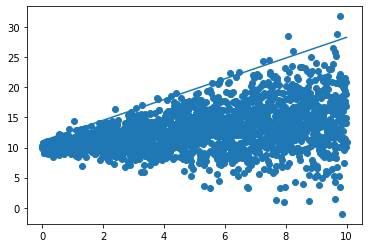

In [12]:
plt.plot(x, y_pred)
# plt.plot(x, y_pred5)
plt.scatter(x, y_normal)